In [1]:
# core python
import dask
import numpy as np
import datetime
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0, inch, foot
from scipy.spatial import cKDTree
import os
import ipywidgets
import time
from string import ascii_lowercase
from matplotlib import rcParams
from matplotlib import gridspec

# SimPEG, discretize
import discretize
from discretize import utils
from SimPEG.electromagnetics import time_domain as tdem
from SimPEG import utils, maps
from pymatsolver import Pardiso

# casing utility code 
import casingSimulations as casingSim

%matplotlib inline

## model parameters

In [2]:
# conductivities
sigma_air = 1e-4
sigma_back = 1e-2
sigma_casing = sigma_back
sigma_casing = 5e6

# relative permeability of the casing
mur_casing = 1.

# casing geometry
casing_diameter = 10e-2  
casing_t = 10e-3
casing_l = 200

# cell size in the z-direction for the mesh
csz = 2.5 
# csz=1.25

Source electrode locations. The source runs along the $\theta = 90^{\circ}$ line

In [3]:
src_a = np.r_[casing_diameter / 2., np.pi/2, 0.]
src_b = np.r_[casing_l, np.pi/2, 0.]

In [4]:
model = casingSim.model.CasingInHalfspace(
    casing_d = casing_diameter - casing_t,  # I use diameter to the center of the casing wall
    casing_l = casing_l,
    casing_t = casing_t, 
    mur_casing = mur_casing,
    sigma_air = sigma_air,
    sigma_casing = sigma_casing,
    sigma_back = sigma_back,
    sigma_inside = sigma_back,
    src_a = src_a,
    src_b = src_b
)
model.filename = "casing.json"

Create the time-stepping for the forward simulation

In [5]:
timeSteps = [
    (1e-6, 20), (1e-5, 30), (3e-5, 30), (1e-4, 40), (3e-4, 30), (1e-3, 20), (1e-2, 17)
]

model.timeSteps = timeSteps

print("The latest time is {:1.1e}s".format(model.timeSteps.sum()))
print("There are {} time-steps in the simulation, {} are unique "
      "(this controls how many matrix factorizations need to be done)".format(
          len(model.timeSteps), len(np.unique(np.diff(model.timeSteps)))
      )
)

The latest time is 2.0e-01s
There are 187 time-steps in the simulation, 7 are unique (this controls how many matrix factorizations need to be done)


Duplicate the model so that we can run a `background` model that does not include casing.

In [6]:
print(model.diffusion_distance(1))


12615.6626101008


In [7]:
model_background = model.copy()
model_background.sigma_casing = model_background.sigma_back
model_background.filename = "background.json"

### create "approximate" models
- treat the well as a solid cylinder
- use a conductivity equal to that product of the conductivity and cross-sectional area of the casing
- to approximate the permeability, I preserve the product of the permeability and the thickness of the casing wall

In [8]:
# preserve product of conductivity and cross-sectional area for solid cylinder 
sigmaA = model.sigma_casing * (model.casing_b**2 - model.casing_a**2)/model.casing_b**2
print(f"The approximate conductivity of the solid we use is {sigmaA:1.1e}")

model_approx_casing = model.copy()
model_approx_casing.sigma_inside = sigmaA
model_approx_casing.sigma_casing = sigmaA
model_approx_casing.filename = "approx_casing.json"

model_solid_steel = model_approx_casing.copy()
model_solid_steel.sigma_inside = model.sigma_casing
model_solid_steel.sigma_casing = model.sigma_casing
model_solid_steel.filename = "solid_steel.json"

The approximate conductivity of the solid we use is 1.8e+06


keep track of the models in a dictionary

In [9]:
model_names = ["casing", "approx_casing", "solid_steel"] 
models = [model, model_approx_casing, model_solid_steel]
model_dict = dict(zip(
    model_names, 
    models 
))

## Mesh

We set up a 3D cylindrical mesh for the simulations. Both the casing and background models will be run on the same mesh. 

In [10]:
model.diffusion_distance()

5701.1071274119095

In [11]:
# Theta discretization
hy = np.ones(12)
hy = hy*2*np.pi / hy.sum()

In [12]:
meshGen = casingSim.mesh.CasingMeshGenerator(
    modelParameters = model, 
    csx1 = model.casing_t/4,
    csx2 = 100,
    domain_x = casing_l,  # use 2.5m cells out to 300m. 
    hy = hy,
    npadx = 8, # 6
    npadz = 17,  #14
#     npadx = 10, 
#     npadz = 19,
    csz = csz,
)
# meshGen.save()

In [13]:
mesh = meshGen.mesh

In [14]:
print("The mesh has {} cells".format(meshGen.mesh.nC))

The mesh has 107136 cells


plot the mesh

/global/homes/l/lheagy/.conda/envs/simpeg37/lib/python3.7/site-packages/matplotlib/projections/polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


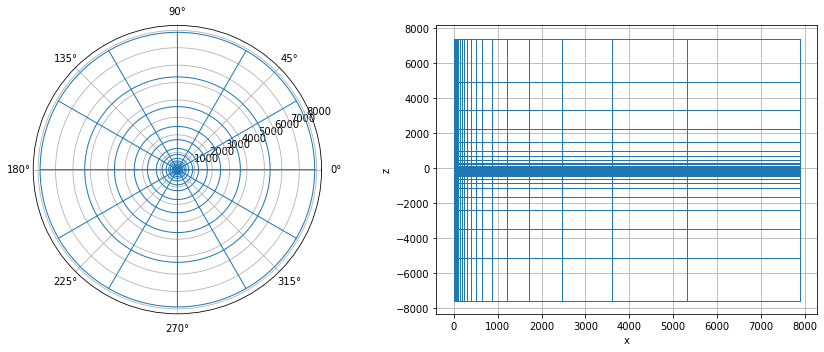

In [15]:
ax = mesh.plotGrid()

## Physical Properties

Now that we have a mesh and a model defined, we populate the mesh with physical properties

In [16]:
physprops_dict = {
    key: casingSim.model.PhysicalProperties(
        modelParameters=m, meshGenerator=meshGen
    )
    for key, m in model_dict.items() 
}


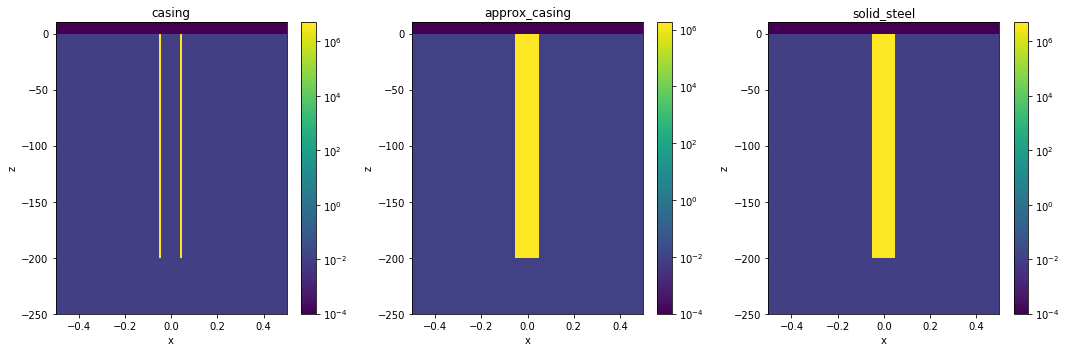

In [17]:
fig, ax = plt.subplots(1, len(model_names), figsize=(5*len(model_names), 5))

xlim = 0.5*np.r_[-1., 1.]
ylim = np.r_[-1.25*casing_l, 10.]

for m, a in zip(model_names, ax):
    physprops_dict[m].plot_sigma(ax=a, pcolorOpts={'norm':LogNorm()})
    a.set_xlim(xlim)
    a.set_ylim(ylim) 
    a.set_title(m)

plt.tight_layout()

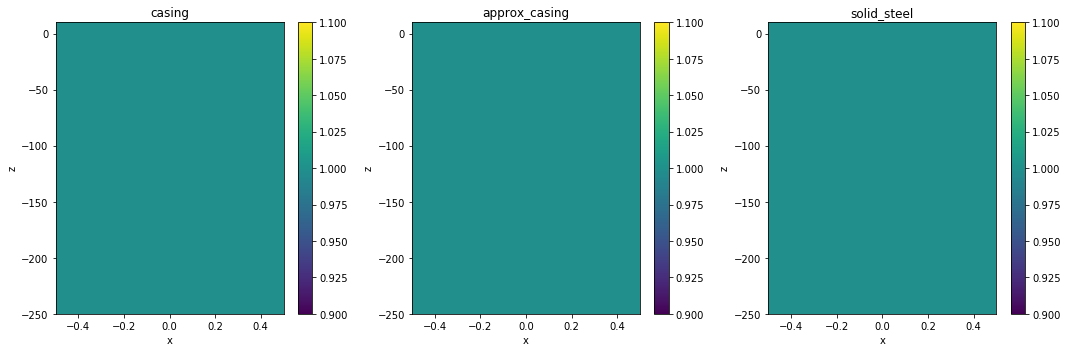

In [18]:
fig, ax = plt.subplots(1, len(model_names), figsize=(5*len(model_names), 5))

xlim = 0.5*np.r_[-1., 1.]
ylim = np.r_[-1.25*casing_l, 10.]

for m, a in zip(model_names, ax):
    physprops_dict[m].plot_mur(ax=a)
    a.set_xlim(xlim)
    a.set_ylim(ylim) 
    a.set_title(m)

plt.tight_layout()

## Survey

The source is a grounded source with one electrode at 1000m and the other electrode connected to the top of the casing. A wire connects them. Note that we will use H-J formulation t solve this problem, so the source is defined as current that goes through the faces of the mesh. 

In [19]:
src_theta = np.pi/2. + mesh.hy[0]/2.
model.src_a[1] = src_theta
model.src_b[1] = src_theta

In [20]:
top_src_a = model.src_a.copy()
top_src_a[2] = -mesh.hz.min()/2.

In [21]:
downhole_src_a = model.src_a.copy()
downhole_src_a[0] = 0.
downhole_src_a[2] = -950.

In [22]:
src_top = casingSim.sources.TopCasingSrc(
    modelParameters=model, 
    meshGenerator=meshGen,
    src_a=top_src_a,
    src_b=model.src_b,
    physics="TDEM",
    filename="top_casing",
)

src_downhole = casingSim.sources.DownHoleCasingSrc(
    modelParameters=model,
    meshGenerator=meshGen,
    src_a=downhole_src_a,
    src_b=model.src_b,
    physics="TDEM",
    filename="downhole",
)

sources = [src_top] #, src_downhole]
srcList = src_top.srcList #+ src_downhole.srcList

In [23]:
casingSimSrcList = casingSim.sources.SourceList(
    filename="sources.json",
    sources = sources  
)

source_list = casingSimSrcList.srcList

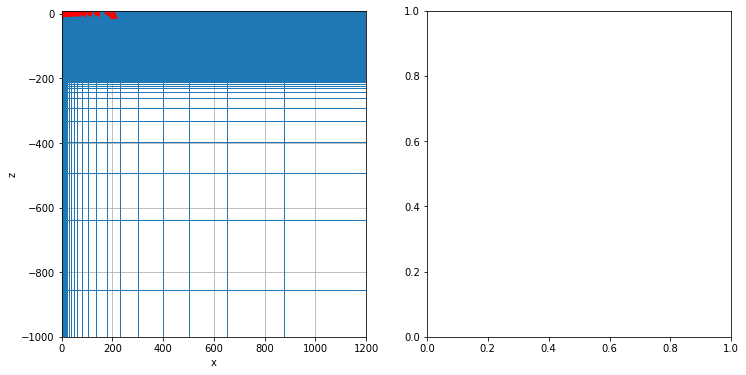

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for a, src in zip(ax, sources): 
    meshGen.mesh.plotGrid(slice='theta', ax=a)
    src.plot(ax=a)

    a.set_xlim([0., 1200])
    a.set_ylim([-1000., 10.])

## Simulation

In [25]:
# run = False
run = True
use_cluster = True

In [26]:
survey = tdem.Survey(source_list)

In [27]:
sim = tdem.Problem3D_h(
    mesh=mesh, survey=survey, sigmaMap=maps.IdentityMap(mesh), solver=Pardiso,
    time_steps=timeSteps
)

In [28]:
import dask
import dask_jobqueue
from dask.distributed import Client
from dask.diagnostics import ProgressBar

In [29]:
len(model_names)*16

48

In [30]:
if use_cluster is True: 
    cluster = dask_jobqueue.SLURMCluster(
        cores=len(model_names),
        processes=len(model_names), memory=f'{32*len(model_names)}GB', 
        project="m3384",
        job_extra = ['--constraint=haswell', '--qos=debug',], 
        death_timeout=360,
    )
    
    print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -A m3384
#SBATCH -n 1
#SBATCH --cpus-per-task=3
#SBATCH --mem=90G
#SBATCH -t 00:30:00
#SBATCH --constraint=haswell
#SBATCH --qos=debug
JOB_ID=${SLURM_JOB_ID%;*}



/global/homes/l/lheagy/.conda/envs/simpeg37/bin/python -m distributed.cli.dask_worker tcp://128.55.224.49:34829 --nthreads 1 --nprocs 3 --memory-limit 32.00GB --name dask-worker--${JOB_ID}-- --death-timeout 360



In [31]:
# dask_jobqueue.SLURMCluster??

In [32]:
if use_cluster is True: 
    client = Client(cluster, threads_per_worker=3)
else: 
    client = Client(threads_per_worker=3, n_workers=1)
client

Client Scheduler: tcp://128.55.224.49:34829 Dashboard: http://128.55.224.49:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [33]:
# @dask.delayed
def run_simulation(m, simulation_params, directory=None, name=None):
    import discretize
    import casingSimulations as casing_sim
    from SimPEG.electromagnetics import time_domain as tdem
    from pymatsolver import Pardiso
        
    if isinstance(simulation_params, str):
        simulation_params = json.loads(simulation_params)
    
    sim = tdem.Problem3D_h.deserialize(simulation_params, trusted=True)
    
    if isinstance(m, str):
        model = casing_sim.model.CasingInHalfspace.deserialize(json.loads(m), trusted=True)
        m = model.sigma(sim.mesh)
    
    sim.solver = Pardiso
    sim.verbose = True
    
    fields = sim.fields(m)
    f = fields[:, '{}Solution'.format(sim._fieldType), :]
    if name is not None: 
        filename = f"{name}.npy"
        tosave = os.path.sep.join([directory, filename]) 
        print(f"saving {tosave}")
        np.save(tosave, f)
    return tosave

In [34]:
if use_cluster is True:
    cluster.scale(3)
    print("cluster scaled")
    cluster

cluster scaled


In [35]:
if run is True: 
    f = {}
    for key, value in physprops_dict.items():
        time = datetime.datetime.now()
        model = model_dict[key]
        directory = f"{time.year}{time.month}{time.day}{time.hour}{os.path.sep}{int(model.casing_l)}m_sigma{model.sigma_back:1.0e}"

        if not os.path.isdir(directory):
            os.makedirs(directory, exist_ok=True)

        model.save(f"{key}.json", directory)

        f[key] = dask.delayed(run_simulation)(
            value.sigma, sim.serialize(), directory, key
        )
    
    

Saved 20198816/200m_sigma1e-02/casing.json
Saved 20198816/200m_sigma1e-02/approx_casing.json
Saved 20198816/200m_sigma1e-02/solid_steel.json


In [ ]:
fields_files = dask.compute(f)[0]

In [ ]:
if run is True: 
    pass
#     fields_files = dask.compute(f)[0]
else:
    fields_files = {}
    directory = '20198413/1000m_sigma1e-02/'
    for key in model_names:
        fields_files[key] = f"{directory}{key}.npy"

load the results into memory and re-populate the fields object (this takes a couple minutes). 

In [ ]:
fields_files

In [ ]:
solution_dict = {}
for key, val in fields_files.items():
    solution_dict[key] = np.load(val)

In [ ]:
m = model_dict['casing']

#### todo: profile this at some point - the fields object should not be this expensive to create

In [ ]:
fields_dict = {}

for key in model_names:
    print(key)
    sim.model = model_dict[key].sigma(sim.mesh)
    fields_dict[key] = sim.fieldsPair(sim)
    fields_dict[key][:, 'hSolution', :] = solution_dict.pop(key)

In [ ]:
# sim_dict = {}
# for key in model_names:
#     sim_dict[key] = sim.copy()
#     sim_dict[key].modelParameters = model_dict[key]
#     sim_dict[key].srcList = sim.srcList

# mesh = sim_dict["casing"].meshGenerator.mesh

In [ ]:
viewer = casingSim.FieldsViewer(
    mesh=mesh, model_parameters_dict=model_dict, survey_dict={key: sim.survey for key in model_names}, 
    fields_dict=fields_dict, model_keys=model_names, primary_key="casing"
)

In [ ]:
# viewer = casingSim.FieldsViewer(
#     model_keys=model_names, sim_dict=sim_dict, fields_dict=fields_dict, primary_key="casing"
# )

In [ ]:
viewer.widget_cross_section(
    defaults={
        "max_depth":1.1*model.casing_l,
        "min_depth":-10,
        "max_r":0.15,
        "theta_ind":3, 
        "view":"j"
    }
)

In [ ]:
from matplotlib import rcParams
rcParams['font.size'] = 14

In [ ]:
viewer.primary = "casing"

In [ ]:
viewer.widget_cross_section(
    defaults={
        "max_depth":1.5*model.casing_l,
        "min_depth":-10,
        "max_r":1.5*model.casing_l,
        "theta_ind":3,
        "view":"j"
    }, 
    figwidth=12
)

In [ ]:
# compute a source term from the charge 

def get_s_e(src, tind, key="approx_casing", primary_key="casing"):
    charge = fields_dict[key][src, 'charge', tind] - fields_dict[primary_key][src, 'charge', tind]
    
    # solve the DC problem

In [ ]:
def dc_src_term(src, tind, key="approx_casing", primary_key="casing"):
    j_diff =  fields_dict[key][src, 'j', tind] - fields_dict[primary_key][src, 'j', tind]
    return - mesh.faceDiv * j_diff

In [ ]:
def theta_index_mirror(theta_ind):
    return (
        theta_ind+int(mesh.vnC[1]/2)
        if theta_ind < int(mesh.vnC[1]/2)
        else theta_ind-int(mesh.vnC[1]/2)
    )

In [ ]:
# plot the divergence of js 

def plot_div_jdiff(
    src, tind, theta_ind=0, model_key="approx_casing", primary_key="casing", ax=None, xlim=None, zlim=None, clim=None
):
    
    if ax is None:
        fig, ax = plt.subplots(1, 1)
           
    plotme = dc_src_term(src, tind, model_key, primary_key)
    
    theta_ind_mirror = theta_index_mirror(theta_ind)
    
    if clim is None:
        clim = np.r_[-1., 1.] * np.max(np.absolute(plotme))
        
    plotme = plotme.reshape(mesh.vnC, order='F')
    mirror_data = discretize.utils.mkvc(
        plotme[:, theta_ind_mirror, :]
    )
    plotme = discretize.utils.mkvc(plotme[:, theta_ind, :])
    mesh2D = discretize.CylMesh([mesh.hx, 1, mesh.hz], x0=mesh.x0)
    
    out = mesh2D.plotImage(
        plotme, ax=ax,
        pcolorOpts = {'cmap': 'RdBu_r'},
        clim=clim,
        mirror_data=mirror_data,
        mirror=True
    )
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)
    plt.colorbar(out[0], ax=ax)


In [ ]:
def widget_div_j(tind, theta_ind, clim):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    plot_div_jdiff(
        survey.srcList[0], tind=tind, theta_ind=theta_ind, ax=ax, xlim=10*np.r_[-1, 1], zlim=[-1.1*model_dict["casing"].casing_l, 10],
        clim=clim*np.r_[-1,1]
    ),

ipywidgets.interact(
    widget_div_j, 
    tind = ipywidgets.IntSlider(min=0, max=sim.nT+1, value=0),
    theta_ind = ipywidgets.IntSlider(min=0, max=len(mesh.hy), value=3),
    clim = ipywidgets.FloatText(value=1.5e-2)
)

In [ ]:
def compute_sm_error(src, tind, key="approx_casing", primary_key="casing", separate=False):
    j_diff =  fields_dict[key][src, 'j', tind] - fields_dict[primary_key][src, 'j', tind]
    dhdt_diff = fields_dict[key][src, 'dhdt', tind] - fields_dict[primary_key][src, 'dhdt', tind]
    
    C = mesh.edgeCurl
    MfRho = mesh.getFaceInnerProduct(1./model_dict[key].sigma(mesh))
    MeMu = mesh.getEdgeInnerProduct(model_dict[key].mur(mesh)*mu_0)
    
    if separate is True:
        return (C.T * MfRho * j_diff, MeMu * dhdt_diff)
    return C.T * MfRho * j_diff + MeMu * dhdt_diff

In [ ]:
def compute_se_error(src, tind, key="approx_casing", primary_key="casing", separate=False):
    h_diff = fields_dict[key][src, 'h', tind] - fields_dict[primary_key][src, 'h', tind]
    j_diff =  fields_dict[key][src, 'j', tind] - fields_dict[primary_key][src, 'j', tind]
    
    C = mesh.edgeCurl
    
    if separate is True:
        return (C * h_diff, -j_diff)
    return C * h_diff -j_diff

In [ ]:
def plot_sm_error(src, tind, theta_ind=0, key="approx_casing", primary_key="casing", term=None, ax=None, clim=None, xlim=None, zlim=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        
    if term in [0, 1]:
        plotme = compute_sm_error(src, tind, key, primary_key, separate=True)[term]
    else:
        plotme = compute_sm_error(src, tind, key, primary_key)

    if len(mesh.hy) == 1:
        plotme = mesh.aveE2CC * plotme
    else:
        plotme = (mesh.aveE2CCV * plotme)[mesh.nC:2*mesh.nC]
    
    theta_ind_mirror = theta_index_mirror(theta_ind)
    plotme = plotme.reshape(mesh.vnC, order="F")
    mirror_data = discretize.utils.mkvc(-plotme[:, theta_ind_mirror, :])
    plotme = discretize.utils.mkvc(plotme[:, theta_ind, :])

    norm = SymLogNorm(
        clim[0] if clim is not None else
        np.max([1e-20, np.min(np.absolute(plotme))])
    )
    clim = clim[1]*np.r_[-1., 1.] if clim is not None else None
    
    mesh2D = discretize.CylMesh([mesh.hx, 1, mesh.hz], x0=mesh.x0)
    
    out = mesh2D.plotImage(
        plotme, ax=ax, pcolorOpts = {'norm': norm}, clim=clim,
        mirror_data=mirror_data, mirror=True
    )

    cb = plt.colorbar(out[0], ax=ax)
    
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)
    


In [ ]:
from matplotlib.colors import LogNorm, SymLogNorm

In [ ]:
def widget_sm(tind, theta_ind, clim_min, clim_max, term):
    fig, ax = plt.subplots(1, 1, figsize=(4, 6))
    plot_sm_error(
        survey.srcList[0], tind=tind, theta_ind=theta_ind, ax=ax, xlim=0.15*np.r_[-1, 1], zlim=[-1.1*model_dict["casing"].casing_l, 10],
        clim=np.r_[clim_min, clim_max], term=term, 
    )

ipywidgets.interact(
    widget_sm, 
    tind = ipywidgets.IntSlider(min=0, max=sim.nT+1, value=0),
    theta_ind = ipywidgets.IntSlider(min=0, max=len(mesh.hy), value=3),
    clim_min = ipywidgets.FloatText(value=1e-6),
    clim_max = ipywidgets.FloatText(value=1e-4),
    term = ipywidgets.ToggleButtons(options=[0, 1, 2], value=2)
)

In [ ]:
def plot_se_error(src, tind, theta_ind=0, key="approx_casing", primary_key="casing", term=None, ax=None, clim=None, xlim=None, zlim=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        
    if term in [0, 1]:
        plotme = compute_se_error(src, tind, key, primary_key, separate=True)[term]
    else:
        plotme = compute_se_error(src, tind, key, primary_key)

    theta_ind_mirror = theta_index_mirror(theta_ind)
    plt_vec = casingSim.utils.face3DthetaSlice(mesh, plotme, theta_ind=theta_ind)
    mirror_data = casingSim.utils.face3DthetaSlice(mesh, plotme, theta_ind=theta_ind_mirror)
    plot_type = "vec"
   

    norm = SymLogNorm(
        clim[0] if clim is not None else
        np.max([1e-20, np.min(np.absolute(plotme))])
    )
    clim = clim[1]*np.r_[-1., 1.] if clim is not None else None
    
    mesh2D = discretize.CylMesh([mesh.hx, 1, mesh.hz], x0=mesh.x0)
    
    out = casingSim.view.plotFace2D(
        mesh2D, plt_vec, ax=ax, range_x=xlim, range_y=zlim,
        sample_grid=(
            np.r_[np.diff(xlim)/100., np.diff(zlim)/100.]
            if xlim is not None and zlim is not None else None
        ),
        log_scale=True,
        clim=clim,
        stream_threshold=clim[0] if clim is not None else None,
        mirror=True,
        mirror_data=mirror_data,
    )
    
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)
    


In [ ]:
def widget_se(tind, theta_ind, clim_min, clim_max, term):
    fig, ax = plt.subplots(1, 1, figsize=(4, 6))
    plot_se_error(
        survey.srcList[0], tind=tind, theta_ind=theta_ind, ax=ax, xlim=0.15*np.r_[-1, 1], zlim=[-1.1*model_dict["casing"].casing_l, 10],
        clim=np.r_[clim_min, clim_max], term=term, 
    )

ipywidgets.interact(
    widget_se, 
    tind = ipywidgets.IntSlider(min=0, max=sim.nT+1, value=0),
    theta_ind = ipywidgets.IntSlider(min=0, max=len(mesh.hy), value=3),
    clim_min = ipywidgets.FloatText(value=1e-6),
    clim_max = ipywidgets.FloatText(value=1e-4),
    term = ipywidgets.ToggleButtons(options=[0, 1, 2], value=2)
)